In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.transform import from_bounds
from shapely.geometry import Polygon

In [2]:
def center(poly:Polygon):
    return(int(poly.bounds[0]+poly.bounds[2]-poly.bounds[0]),
           int(poly.bounds[1]+poly.bounds[3]-poly.bounds[1]))

class Box:
    def __init__(self, bounds=None, left:int=0, bottom:int=0, right:int=0, top:int=0):
        if bounds is not None: self.left,self.bottom,self.right,self.top = bounds
        else: self.left,self.bottom,self.right,self.top = left,bottom,right,top
        self.width, self.height = self.right -self.left, self.top -self.bottom
    def __str__(self):
        return "left:{} bottom:{} right:{} top:{} width:{} height:{}".format(
            self.left, self.bottom, self.right, self.top, self.width, self.height)
    def in_bounds(self, x:int, y:int) -> bool:
        return self.left < x < self.right and self.bottom < y < self.top
    
def get_shapes_in_box(gdf: GeoDataFrame, box: Box) -> GeoDataFrame:
    return gdf[gdf.geometry.apply(
        lambda d: box.in_bounds(
            x = center(Polygon(d))[0],
            y = center(Polygon(d))[1]
        ))]

In [13]:
shapefile = gpd.read_file("/home/becode/Projects/3D_House/Shapes/ANTWERPEN_L72_2020/Bpn_CaBl.shp")
print(type(shapefile.loc[0].geometry))
#tif = rio.open("./k15_1_2_1_1_0.tif")
#box = Box(tif.bounds)
#crop_shapes = get_shapes_in_box(shapefile, box)
#crop_shapes.to_file("./crop_beacon_shapes.shp")

<class 'shapely.geometry.polygon.Polygon'>


<Figure size 1440x1440 with 0 Axes>

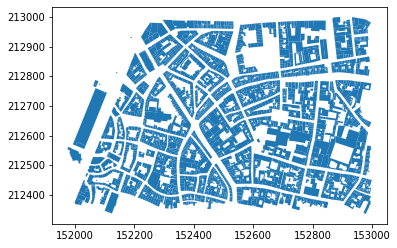

In [17]:
crop_shapes = gpd.read_file("./crop_beacon_shapes.shp")
plt.figure(figsize=(20,20))
crop_shapes.plot()

/home/becode/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/home/becode/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/becode/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

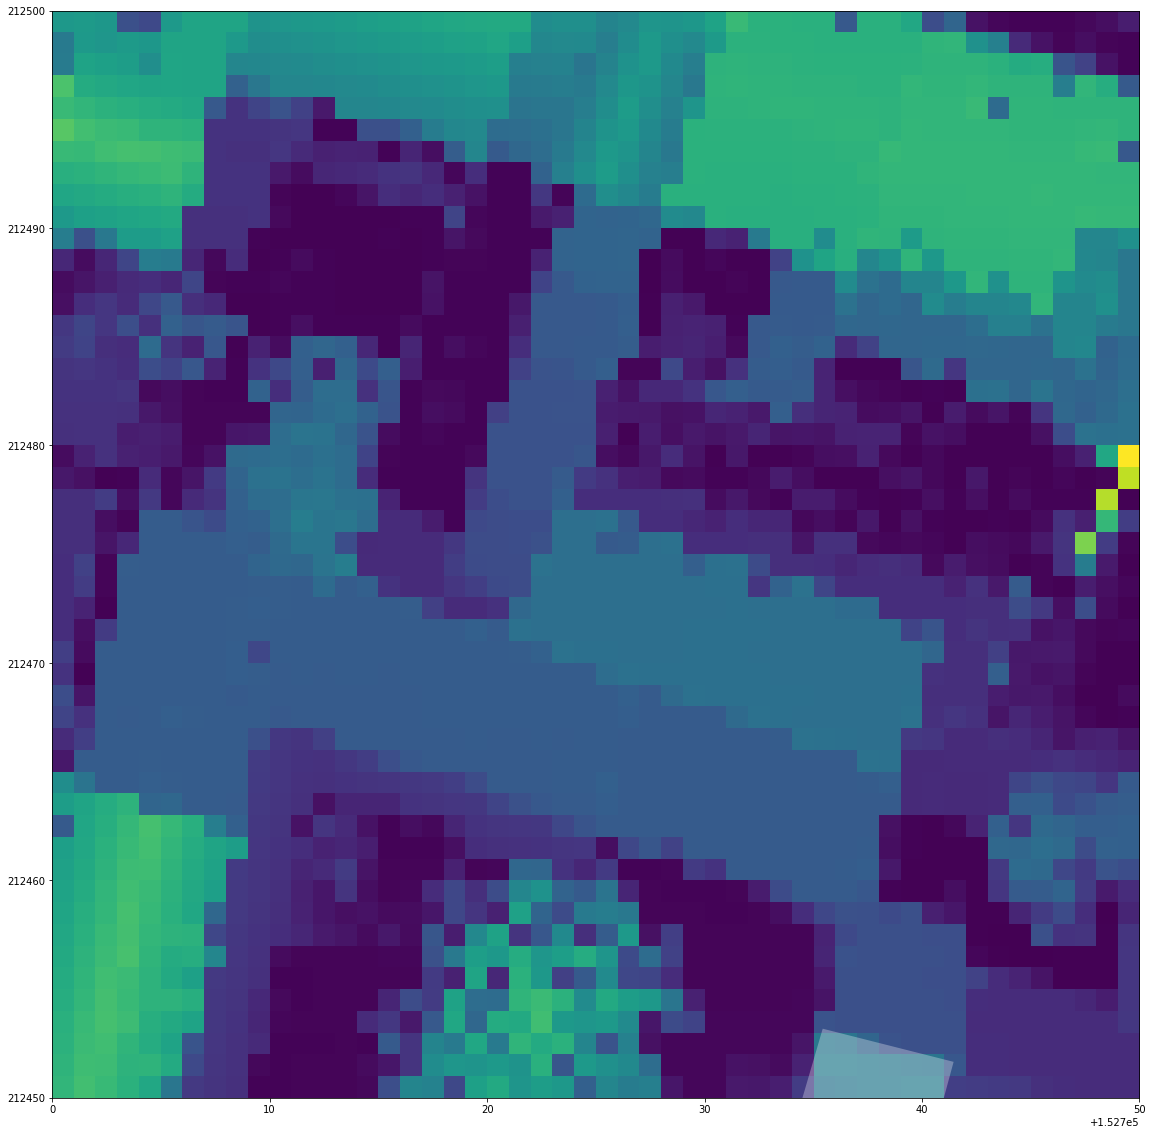

median:18.299999237060547


,0
count,15.000000
mean,18.240000
std,0.620829
min,16.400000
25%,17.950000
50%,18.299999
75%,18.700000
max,18.900000


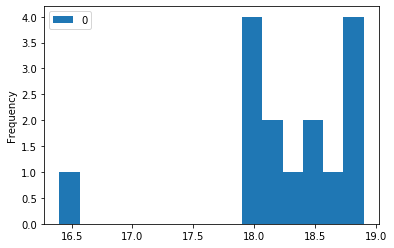

In [153]:
shapefile = gpd.read_file("./crop_beacon_shapes.shp")
tif = rio.open("./k15_1_2_1_1_0.tif")
shapes = gpd.read_file("./beacon_shapes.shp")
arr = np.array(tif.read(1))
box = Box(tif.bounds)
meta = tif.meta

width = meta["width"] = 50
height = meta["height"] = 50
x, y = 700,500
slicex = slice(int(x), int(x +width))
slicey = slice(int(y), int(y +height))
meta["transform"] = from_bounds(
    box.left + slicex.start,
    box.top - slicey.stop,
    box.left + slicex.stop,
    box.top - slicey.start,
    width, height)
with rio.open("./crop_math.tif", "w", **meta) as out:
    out.write(arr[slicey,slicex], indexes =1)
crop = rio.open("./crop_math.tif")
crop_box = Box(crop.bounds)
crop_shapes = get_shapes_in_box(shapefile, crop_box)
crop_shapes.reset_index(inplace=True)
idx = 0
crop_shapes["Enabled"] = False
crop_shapes["Enabled"][idx] = True
crop_shapes[crop_shapes.Enabled].plot(figsize=(20,20),alpha=.3, color="white")
show(crop)
out_image, out_transform = mask(crop, shapes=[crop_shapes.iloc[idx].geometry], crop=True, invert=False)
li = []
for y in out_image[0]:
    for x in y:
        if x > 0:
            li.append(x)
li.sort()
#li = [int(i) for i in li]
li = [round(i, 1) for i in li]
#li = li[2:]
df = pd.DataFrame(li)
#print(df.agg(["count","min","max","mean","median","std"]))
df.plot(kind="hist", bins = len(li))
print(f"median:{df.median()[0]}")
df.describe()